In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import random
import datetime


Bad key "text.kerning_factor" on line 4 in
C:\Users\zhouxiaoqian\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data = pd.read_csv("cleaned_structured_data.csv", sep = ";")
data = data.set_index(["id", "date"])

In [3]:
data = data[data["daysOfHospital"] >= 10]

In [4]:
forecast_domains = ["ADM", "ETN", "STM"]
other_domains = ["ATT", "BER", "ENR", "FAC", "INS", "MBW", "STM"]
forecast_features = ["temperature", "bloodPressure", "o2Saturation"]

for domain in forecast_domains:
    for i in range(1, 4):
        forecast_data = pd.read_csv(domain + "_day" + str(i) + ".csv", sep = ";")
        forecast_data = forecast_data.set_index(["id", "date"])
        forecast_data.columns = [domain + "_f" + str(i)]
        data = data.join(forecast_data)

for domain in other_domains:
    data[domain + "_f"] = [0] * len(data)
    
for i in range(len(data)):
    idx = data.iloc[i].name
    for j in range(1, 4):
        date = str(pd.to_datetime(idx[1]) - datetime.timedelta(days = j))[:10]
        new_idx = (idx[0], date)
        if new_idx in data.index:
            for domain in other_domains:     
                data.loc[idx, domain + "_f" + str(j)] = data.loc[new_idx][domain]

for feature in forecast_features:
    for i in range(1, 4):
        forecast_data = pd.read_csv(feature + "_day" + str(i) + ".csv", sep = ";")
        forecast_data = forecast_data.set_index(["id", "date"])
        forecast_data.columns = [feature + "_f" + str(i)]
        data = data.join(forecast_data)

In [5]:
for domain in forecast_domains:
    for i in range(1, 4):
        data[domain + "-" + str(i)] = data[domain]
        
for i in range(len(data)):
    idx = data.iloc[i].name
    date = str(pd.to_datetime(idx[1]) - datetime.timedelta(days = 1))[:10]
    new_idx = (idx[0], date)
    if new_idx in data.index:
        for domain in forecast_domains:
            for j in range(1, 4):
                data.loc[idx, domain + "-" + str(j)] = data.loc[new_idx][domain]
                
for domain in forecast_domains:        
    data[domain + "-3days"] = (data[domain + "-1"] + data[domain + "-2"] + data[domain]) / 3

In [6]:
data = data.reset_index().set_index("id")
data["date"] = pd.to_datetime(data["date"])
data["startDay"] = data.groupby("id").min()["date"]
data["endDay"] = data.groupby("id").max()["date"]
data["daysOfHospital"] = (data["endDay"] - data["startDay"]).astype("timedelta64[D]").astype("int") + 1
data["dischargeIn3Days"] = (data["daysOfHospital"] <= data["day"] + 7) & ((data["dischargeTo"] == "Home") | (data["dischargeTo"] == "Nursing home") | (data["dischargeTo"] == "Rehabilitation centre"))

data["gender"] = np.where(data["gender"] == "Vrouw" , 0, 1)
data["admitFrom"] = np.where(data["admitFrom"] != "Home", data["admitFrom"], 0)
data["admitFrom"] = np.where(data["admitFrom"] != "Hospital", data["admitFrom"], 1)
data["admitFrom"] = np.where(data["admitFrom"] != "Nursing or Rehabilitation", data["admitFrom"], 2)
data["gender"] = pd.to_numeric(data["gender"])
data["admitFrom"] = pd.to_numeric(data["admitFrom"])

In [8]:
data.columns

Index(['date', 'ADM', 'ATT', 'BER', 'ENR', 'ETN', 'FAC', 'INS', 'MBW', 'STM',
       'BMI', 'bloodPressure', 'temperature', 'o2Saturation', 'age',
       'admitFrom', 'dischargeTo', 'specialism', 'gender', 'firstDay', 'day',
       'daysOfHospital', 'ADM_f1', 'ADM_f2', 'ADM_f3', 'ETN_f1', 'ETN_f2',
       'ETN_f3', 'STM_f1', 'STM_f2', 'STM_f3', 'ATT_f', 'BER_f', 'ENR_f',
       'FAC_f', 'INS_f', 'MBW_f', 'STM_f', 'ATT_f1', 'BER_f1', 'ENR_f1',
       'FAC_f1', 'INS_f1', 'MBW_f1', 'ATT_f2', 'BER_f2', 'ENR_f2', 'FAC_f2',
       'INS_f2', 'MBW_f2', 'ATT_f3', 'BER_f3', 'ENR_f3', 'FAC_f3', 'INS_f3',
       'MBW_f3', 'temperature_f1', 'temperature_f2', 'temperature_f3',
       'bloodPressure_f1', 'bloodPressure_f2', 'bloodPressure_f3',
       'o2Saturation_f1', 'o2Saturation_f2', 'o2Saturation_f3', 'ADM-1',
       'ADM-2', 'ADM-3', 'ETN-1', 'ETN-2', 'ETN-3', 'STM-1', 'STM-2', 'STM-3',
       'ADM-3days', 'ETN-3days', 'STM-3days', 'startDay', 'endDay',
       'dischargeIn3Days'],
      dtype='

In [9]:
# forecast discharge using true data
features = ['ADM', 'ATT', 'BER', 'ENR', 'ETN', 'FAC', 'INS', 'MBW', 'STM', 'BMI', 'temperature', 'bloodPressure', 'o2Saturation', 'age', 'day', 'gender', 'admitFrom', "ADM-3days", "ETN-3days", "STM-3days"]

X = data
y = data["dischargeIn3Days"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBClassifier()
model.fit(X_train[features], y_train)
y_hat = model.predict(X_test[features])

cm = confusion_matrix(y_hat, y_test)
confusion_matrix_calculate(cm)

recall:0.8978494623655914
precision:0.7767441860465116
accuracy:0.9317718940936863
tnr:0.9396984924623115
fpr:0.06030150753768844
fnr:0.10215053763440861


In [11]:
X1_test = X_test
y1_test = X1_test["dischargeIn3Days"]
for domain in forecast_domains:
    X1_test.loc[:,domain] = X1_test.loc[:,domain + "_f1"]
    X1_test.loc[:,domain + "-3days"] = (X1_test.loc[:,domain + "-1"] + X1_test.loc[:,domain + "-2"] + X1_test.loc[:,domain]) / 3
for domain in other_domains:
    X1_test.loc[:,domain] = X1_test.loc[:,domain + "_f1"]
for feature in forecast_features:
    X1_test.loc[:,feature] = X1_test.loc[:,feature + "_f1"]

C:\Users\zhouxiaoqian\anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [747]:
y_hat1 = model.predict(X1_test[features])
cm = confusion_matrix(y_hat1, y1_test)
confusion_matrix_calculate(cm)

recall:0.9254385964912281
precision:0.9547511312217195
accuracy:0.97
tnr:0.9851190476190477
fpr:0.01488095238095238
fnr:0.07456140350877193


In [13]:
X1_test

,date,ADM,ATT,BER,ENR,ETN,FAC,INS,MBW,STM,...,ETN-3,STM-1,STM-2,STM-3,ADM-3days,ETN-3days,STM-3days,startDay,endDay,dischargeIn3Days
id,,,,,,,,,,,,,,,,,,,,,
857863,2020-12-22,0.575190,2.740472,2.531250,1.830621,0.666675,3.573242,3.304688,2.511719,3.331752,...,0.691797,3.331752,3.331752,3.331752,0.344440,0.683423,3.331752,2020-12-10,2021-02-19,False
717033,2020-12-06,3.398374,NaN,NaN,NaN,2.934324,NaN,NaN,NaN,2.714206,...,3.814453,4.312500,4.312500,4.312500,2.601281,3.521077,3.779735,2020-12-06,2021-01-05,False
164937,2020-06-04,0.984884,3.896094,2.644531,1.699544,0.909863,3.221637,3.009766,1.682953,1.909668,...,0.927734,1.909668,1.909668,1.909668,0.959444,0.921777,1.909668,2020-03-31,2020-07-15,False
550356,2021-01-14,0.973389,2.740472,2.621094,1.596436,0.704619,2.235352,0.770508,3.558594,2.305664,...,0.690918,2.305664,2.305664,2.305664,0.926310,0.695485,2.305664,2020-12-18,2021-02-12,False
633512,2020-04-10,0.721717,2.000000,2.623047,1.791992,0.812192,2.578125,1.804199,2.835938,3.053426,...,0.685221,3.053426,3.053426,3.053426,0.503467,0.727545,3.053426,2020-03-30,2020-04-18,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170753,2020-04-22,0.553603,2.740472,2.501864,2.078125,0.818837,3.544224,3.000000,2.707645,2.609375,...,0.798706,2.609375,2.609375,2.609375,0.392440,0.805416,2.609375,2020-04-07,2020-05-03,False
36342,2020-03-30,3.499228,2.740472,2.501864,1.670118,3.446798,3.843750,3.404297,2.266602,4.105469,...,3.953125,4.105469,4.105469,4.105469,3.602607,3.784349,4.105469,2020-03-15,2020-04-03,True
724374,2021-02-06,0.822055,2.740472,2.501864,1.794922,0.836167,3.941406,2.695312,3.558594,2.306641,...,0.867025,2.306641,2.306641,2.306641,0.826058,0.856739,2.306641,2021-01-05,2021-02-16,False


In [12]:
y_hat1 = model.predict(X1_test[features])
cm = confusion_matrix(y_hat1, y1_test)
confusion_matrix_calculate(cm)

recall:0.9209039548022598
precision:0.7581395348837209
accuracy:0.9327902240325866
tnr:0.9354037267080745
fpr:0.06459627329192547
fnr:0.07909604519774012


In [748]:

y2_test = X2_test["dischargeIn3Days"]
for domain in forecast_domains:
    X2_test.loc[:,domain] = X2_test.loc[:,domain + "_f2"]
    X2_test.loc[:,domain + "-3days"] = (X2_test.loc[:,domain + "-2"] + X2_test.loc[:,domain + "_f1"] + X2_test.loc[:,domain]) / 3
for domain in other_domains:
    X2_test.loc[:,domain] = X2_test.loc[:,domain + "_f2"]
for feature in forecast_features:
    X2_test.loc[:,feature] = X2_test.loc[:,feature + "_f2"]

In [749]:
y_hat2 = model.predict(X2_test[features])
cm = confusion_matrix(y_hat2, y2_test)
confusion_matrix_calculate(cm)

recall:0.919047619047619
precision:0.9234449760765551
accuracy:0.9614035087719298
tnr:0.9751937984496124
fpr:0.024806201550387597
fnr:0.08095238095238096


In [8]:
def confusion_matrix_calculate(cm):
    recall = cm[1][1] / (cm[1][1] + cm[1][0])
    precision = cm[1][1] / (cm[1][1] + cm[0][1])
    accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
    tnr = cm[0][0] / (cm[0][0] + cm[0][1])
    fpr = cm[0][1] / (cm[0][0] + cm[0][1])
    fnr = cm[1][0] / (cm[1][0] + cm[1][1])
    print("recall:" + str(recall))
    print("precision:" + str(precision))
    print("accuracy:" + str(accuracy))
    print("tnr:" + str(tnr))
    print("fpr:" + str(fpr))
    print("fnr:" + str(fnr))

In [751]:

y3_test = X3_test["dischargeIn3Days"]
for domain in forecast_domains:
    X3_test.loc[:,domain] = X3_test.loc[:,domain + "_f3"]
    X3_test.loc[:,domain + "-3days"] = (X3_test.loc[:,domain + "_f1"] + X3_test.loc[:,domain + "_f2"] + X3_test.loc[:,domain]) / 3
for domain in other_domains:
    X3_test.loc[:,domain] = X3_test.loc[:,domain + "_f3"]
for feature in forecast_features:
    X3_test.loc[:,feature] = X3_test.loc[:,feature + "_f3"]

In [752]:
y_hat3 = model.predict(X3_test[features])
cm = confusion_matrix(y_hat3, y3_test)
confusion_matrix_calculate(cm)

recall:0.8913043478260869
precision:0.8497409326424871
accuracy:0.9382871536523929
tnr:0.9524590163934427
fpr:0.047540983606557376
fnr:0.10869565217391304


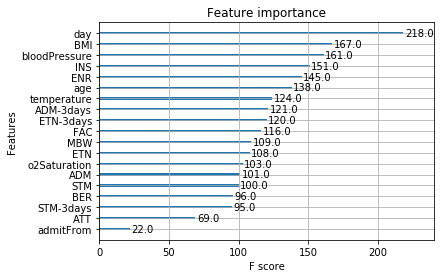

In [753]:
xgb.plot_importance(model, max_num_features=30)
